# Chapter 2 - Exercise 4
#### Author: *John Benedick Estrada*
---
**Exercise:** There are actually two kinds of ER graphs.  The one we generated in the chapter, $G(n, p)$, is characterized by two parameters, the number of nodes and the probability of an edge between nodes.

An alternative definition, denoted $G(n, m)$, is also characterized by two parameters: the number of nodes, $n$, and the number of edges, $m$.  Under this definition, the number of edges is fixed, but their location is random.

Repeat the experiments we did in this chapter using this alternative definition.  Here are a few suggestions for how to proceed:

1. Write a function called `m_pairs` that takes a list of nodes and the number of edges, $m$, and returns a random selection of $m$ edges.  A simple way to do that is to generate a list of all possible edges and use `random.sample`.

2. Write a function called `make_m_graph` that takes $n$ and $m$ and returns a random graph with $n$ nodes and $m$ edges.

3. Make a version of `prob_connected` that uses `make_m_graph` instead of `make_random_graph`.

4. Compute the probability of connectivity for a range of values of $m$.

How do the results of this experiment compare to the results using the first type of ER graph?

In [1]:
%matplotlib inline

import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from typing import Iterator, Tuple  # For type hints.
from utils import three_frame, decorate, legend, underride

In [2]:
# Set seed to have consistent results.
random.seed(0)

#### Implementation of `m_graph`

##### Function definitions from the Think Complexity 2nd Edition: Chapter 2
Source: https://github.com/AllenDowney/ThinkComplexity2/blob/master/notebooks/chap02.ipynb

In [3]:
def all_pairs(nodes: Iterator):
    """
    NOTE: Type hints are added by mine.
    """
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v


def is_connected(G: nx.Graph):
    """
    NOTE: Type hints are added by mine.
    """
    start = next(iter(G))
    reachable = reachable_nodes_precheck(G, start)
    return len(reachable) == len(G)

My implementation of `reachable_nodes` with neighbor precheck from `/src/solutions/exercise2_3.ipynb`.

In [4]:
def reachable_nodes_precheck(G, start):
    seen = set()
    stack = [start]
    while stack:
        node = stack.pop()
        if node not in seen:
            seen.add(node)
            for neighbor in G.neighbors(node):
                if neighbor not in seen:
                    seen.add(neighbor)
    return seen

##### My implementation of `m_pairs` and `make_m_graph`

In [5]:
def m_pairs(nodes: Iterator, m: int):
    """
    Randomly select `m` number of edges from all possible edges that can be
    formed with the given set of nodes `nodes`.
    """
    yield from random.sample(list(all_pairs(nodes)), m)


def make_m_graph(n: int, m: int):
    """
    Make a random graph with `n` number of nodes and `m` number of edges.
    """
    G = nx.Graph()
    nodes = range(n)
    rand_pairs = m_pairs(nodes, m)
    G.add_nodes_from(nodes)
    G.add_edges_from(rand_pairs)
    return G


def prob_connected(n: int, m: int, iters: int=100):
    """
    `prob_connected`
    Compute the probability of connectivity.
    """
    tf = [is_connected(make_m_graph(n, m))
          for i in range(iters)]
    return np.mean(tf)

An alternative and potentially faster implementation of `make_m_graph` was written. This new function uses memoization--caching results of expensive operations.

In [6]:
def m_pairs_with_range(n: int, m: int, __all_pairs: dict={}):
    """
    Randomly select `m` number of edges from all possible edges that can be
    formed with the given set of integer nodes.
    
    This stores generated list of edges for given `n`.
    """
    # Try to get the pre-calculated list of all possible edges.
    try:
        all_pair_list = __all_pairs[n]
    except KeyError:
        all_pair_list = list(all_pairs(range(n)))
        __all_pairs[n] = all_pair_list

    yield from random.sample(all_pair_list, m)


def memoized_make_m_graph(n: int, m: int):
    """
    Make a random graph with `n` number of nodes and `m` number of edges.
    
    This uses `m_pairs_with_range` instead of `m_pairs`.
    """
    G = nx.Graph()
    nodes = range(n)
    rand_pairs = m_pairs_with_range(n, m)
    G.add_nodes_from(nodes)
    G.add_edges_from(rand_pairs)
    return G


def memoized_prob_connected(n: int, m: int, iters: int=100):
    """
    `prob_connected`
    Compute the probability of connectivity.
    """
    tf = [is_connected(memoized_make_m_graph(n, m))
          for i in range(iters)]
    return np.mean(tf)

The memoized version of `make_m_graph` is faster for a given set of inputs than the original `make_m_graph`. So from hereon we will use `memoized_make_m_graph` for generating graphs.

In [7]:
%timeit make_m_graph(100, 100)
%timeit memoized_make_m_graph(100, 100)

969 µs ± 71.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
206 µs ± 23.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


#### Example of `memoized_make_m_graph`

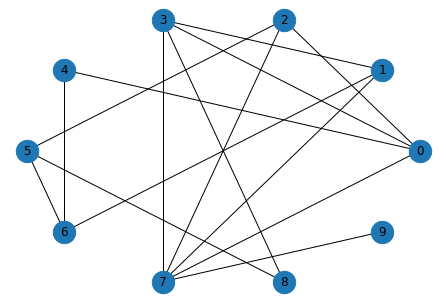

In [8]:
rand_graph = memoized_make_m_graph(n=10, m=15)
nx.draw_circular(rand_graph, 
                 node_color="C0", 
                 node_size=500, 
                 with_labels=True)

#### Probability of connectivity across all possible values of `m`

Current n: 300
Current n: 100
Current n: 30


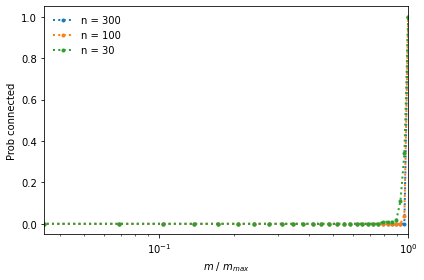

In [9]:
node_counts = [300, 100, 30]
max_m_num = 30
x_lower, x_upper = 1, 1

for n in node_counts:
    print("Current n: {}".format(n))

    # `max_m`: Maximum number of edges possible given the number of nodes.
    # TODO: Source this
    max_m = int(n*(n - 1)/2)
    
    # NOTE: Cast to `set` to compress the range of `m` values.
    m_range = np.array(sorted(set(np.linspace(0, max_m, num=max_m_num, dtype=int))))
    m_range_norm = m_range/np.max(m_range)  # Normalized `m` array.
    m_prob = [memoized_prob_connected(n, m) for m in m_range]
    plt.plot(m_range_norm, m_prob, ":.", label="n = {}".format(n))
    
    x_lower = np.min(m_range_norm[np.where(m_range_norm > 0)])
    x_upper = np.max(m_range_norm)


decorate(xlabel='$m$ / $m_{max}$',
         ylabel='Prob connected',
         xscale='log', 
         xlim=(x_lower, x_upper),
         loc='upper left')

plt.show()

Huh. The result is different from the book. So probably, WS is not robust.